In [1]:
import os
import sys
import warnings
from datetime import datetime
from functools import partial

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# import febrisk
lib_path = os.path.join(os.path.abspath('.'), '..\\..')
sys.path.append(lib_path)
from febrisk.option import bsm, bt_american
from febrisk.risk import VaR, expected_shortfall

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

# Problem 1
- Current Stock Price $165
- Strike Price $165
- Current Date 03/13/2022
- Options Expiration Date 04/15/2022
- Risk Free Rate of 0.25%
- Continuously Compounding Coupon of 0.53%

Implement the closed form greeks for GBSM. Implement a finite difference derivative calculation.  
Compare the values between the two methods for both a call and a put.  
Implement the binomial tree valuation for American options with and without discrete dividends. Assume
the stock above:  
- Pays dividend on 4/11/2022 of $0.88  

Calculate the value of the call and the put. Calculate the Greeks of each.  
What is the sensitivity of the put and call to a change in the dividend amount?  

## Solutions

In [2]:
def cal_ttm(curr_date, expire_date):
    return (expire_date - curr_date).days / 365

price = 165
strike = 165
r_f = 0.0025
div_rate = 0.0053
ivol = 0.2
curr_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15) 
ttm = cal_ttm(curr_date, expire_date)

### 1. European Options: Greeks

In [3]:
import inspect
from functools import wraps
from typing import Callable

def first_derivative(f, x, delta):
    return (f(x+delta) - f(x-delta)) / (2*delta)


def second_derivative(f, x, delta):
    return (f(x+delta) + f(x-delta) - 2*f(x)) / delta**2


def cal_partial_derivative(f: Callable, order: int, arg_name: str, delta=1e-3) -> Callable:
    """
    Return the partial derivative of a function with respect to one of its arguments.
    
    params:
        - f : the original function
        - order: the order of derivative
        - arg_name: the name of the variable that the partial derivative is with respect to
        - delta: precision
    """
    arg_names = list(inspect.signature(f).parameters.keys())  # the name of funtion f's arguments 
    derivative_fs = {1: first_derivative, 2: second_derivative}

    @wraps(f)
    def wrapper(*args, **kwargs):
        args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
        arg_val = args_dict.pop(arg_name)

        def partial_f(x):
            p_kwargs = {arg_name:x, **args_dict}
            return f(**p_kwargs)
        
        return derivative_fs[order](partial_f, arg_val, delta)

    return wrapper


# simple test cases
def foo(a, b, c=3):
    return a**2 + 3*b + c


def almost_equal(a, b, delta=1e-5):
    return abs(a - b) < delta


df_da = cal_partial_derivative(foo, 1, 'a')
df_db =  cal_partial_derivative(foo, 1, 'b')
d2f_da2 = cal_partial_derivative(foo, 2, 'a')

print(almost_equal(df_da(3, 4, c=5), 2*3))
print(almost_equal(df_db(3, 4, c=5), 3))
print(almost_equal(d2f_da2(3, 4, c=5), 2))


True
True
True


#### 1.1 Delta

In [4]:
cal_delta_num = cal_partial_derivative(bsm, 1, 'price')

def cal_d1(price, strike, ttm, carry_cost, ivol):
    return (np.log(price/strike) + (carry_cost + 0.5*ivol**2)*ttm) / (ivol*np.sqrt(ttm))

def cal_d2(d1, ivol, ttm):
    return d1 - ivol*np.sqrt(ttm)


def cal_delta(is_call: bool, price, strike, ttm, r_f, div_rate, ivol):
    b = r_f - div_rate  # cost of carry = risk free rate - dividend rate
    is_call = 0 if is_call else 1
    N = scipy.stats.norm(0, 1).cdf
    d1 = cal_d1(price, strike, ttm, b, ivol)
    return np.exp((b-r_f)*ttm) * (N(d1) - is_call)

call_delta_closed = cal_delta(True, price, strike, ttm, r_f, div_rate, ivol)
call_delta_num = cal_delta_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(call_delta_closed, call_delta_num))

put_delta_closed = cal_delta(False, price, strike, ttm, r_f, div_rate, ivol)
put_delta_num = cal_delta_num(False, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(put_delta_closed, put_delta_num))
print(f"Delta: Call: {call_delta_closed:.2f}, Put: {put_delta_closed:.2f}")

True
True
Delta: Call: 0.51, Put: -0.49


#### 1.2 Gamma

In [5]:
cal_gamma_num = cal_partial_derivative(bsm, 2, 'price')

def cal_gamma(price, strike, ttm, r_f, div_rate, ivol):
    b = r_f - div_rate
    d1 = cal_d1(price, strike, ttm, b, ivol)
    f = scipy.stats.norm(0, 1).pdf 
    return (f(d1) * np.exp((b-r_f)*ttm)) / (price * ivol * np.sqrt(ttm))  

gamma_closed = cal_gamma(price, strike, ttm, r_f, div_rate, ivol)
gamma_num = cal_gamma_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(gamma_closed, gamma_num))
print(f"Gamma: {gamma_closed:.2f}")

True
Gamma: 0.04


#### 1.3 Vega

In [6]:
cal_vega_num = cal_partial_derivative(bsm, 1, 'ivol')

def cal_vega(price, strike, ttm, r_f, div_rate, ivol):
    b = r_f - div_rate
    d1 = cal_d1(price, strike, ttm, b, ivol)
    f = scipy.stats.norm(0, 1).pdf 
    return price * np.exp((b-r_f)*ttm)*f(d1)*np.sqrt(ttm)

vega_closed = cal_vega(price, strike, ttm, r_f, div_rate, ivol)
vega_num = cal_vega_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(vega_closed, vega_num))
print(f"Vega: {vega_closed:.2f}")

True
Vega: 19.78


#### 1.4 Theta

In [7]:
def cal_theta_num(is_call, price, strike, ttm, r_f, div_rate, ivol):
    cal_neg_theta = cal_partial_derivative(bsm, 1, 'ttm')
    return -1 * cal_neg_theta(is_call, price, strike, ttm, r_f, div_rate, ivol)

def cal_theta(is_call, price, strike, ttm, r_f, div_rate, ivol):
    is_call = 1 if is_call else -1
    b = r_f - div_rate
    f = scipy.stats.norm(0, 1).pdf 
    N = scipy.stats.norm(0, 1).cdf
    d1 = cal_d1(price, strike, ttm, b, ivol)
    d2 = cal_d2(d1, ivol, ttm)

    term1 = -price * np.exp((b-r_f)*ttm) * f(d1) * ivol / (2 * np.sqrt(ttm))
    term2 = -1 * is_call * (b - r_f) * price * np.exp((b-r_f)*ttm) * N(d1*is_call)
    term3 = -1 * is_call * r_f * strike * np.exp(-r_f*ttm) * N(d2*is_call)

    return term1 + term2 + term3

call_theta_closed = cal_theta(True, price, strike, ttm, r_f, div_rate, ivol)
call_theta_num = cal_theta_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(call_theta_closed, call_theta_num, delta=1e-3))

put_theta_closed = cal_theta(False, price, strike, ttm, r_f, div_rate, ivol)
put_theta_num = cal_theta_num(False, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(put_theta_closed, put_theta_num, delta=1e-3))
print(f"Theta: Call: {call_theta_closed:.2f}, Put: {put_theta_closed:.2f}")

True
True
Theta: Call: -21.63, Put: -22.09


#### 1.5 Rho

In [8]:
cal_rho_num = cal_partial_derivative(bsm, 1, 'r_f')

def cal_rho(is_call, price, strike, ttm, r_f, div_rate, ivol):
    is_call = 1 if is_call else -1
    b = r_f - div_rate 
    N = scipy.stats.norm(0, 1).cdf
    d1 = cal_d1(price, strike, ttm, b, ivol)
    d2 = cal_d2(d1, ivol, ttm)
    return is_call * ttm * strike * np.exp(-r_f*ttm)*N(is_call*d2)


call_rho_closed = cal_rho(True, price, strike, ttm, r_f, div_rate, ivol)
call_rho_num = cal_rho_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(call_rho_closed, call_rho_num, delta=1e-3))

put_rho_closed = cal_rho(False, price, strike, ttm, r_f, div_rate, ivol)
put_rho_num = cal_rho_num(False, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(put_rho_closed, put_rho_num, delta=1e-3))
print(f"Rho: Call: {call_rho_closed:.2f}, Put: {put_rho_closed:.2f}")

True
True
Rho: Call: 7.25, Put: -7.66


#### 1.6 Carry Rho

In [9]:
def cal_carry_rho_num(is_call, price, strike, ttm, r_f, div_rate, ivol):
    cal_neg_rho = cal_partial_derivative(bsm, 1, 'div_rate')
    return -1 * cal_neg_rho(is_call, price, strike, ttm, r_f, div_rate, ivol)

def cal_carry_rho(is_call, price, strike, ttm, r_f, div_rate, ivol):
    is_call = 1 if is_call else -1
    b = r_f - div_rate 
    N = scipy.stats.norm(0, 1).cdf
    d1 = cal_d1(price, strike, ttm, b, ivol)
    return is_call * ttm * price * np.exp((b-r_f)*ttm)*N(is_call*d1)

call_carry_rho_closed = cal_carry_rho(True, price, strike, ttm, r_f, div_rate, ivol)
call_carry_rho_num = cal_carry_rho_num(True, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(call_carry_rho_closed, call_carry_rho_num))

put_carry_rho_closed = cal_carry_rho(False, price, strike, ttm, r_f, div_rate, ivol)
put_carry_rho_num = cal_carry_rho_num(False, price, strike, ttm, r_f, div_rate, ivol)
print(almost_equal(put_carry_rho_closed, put_carry_rho_num))
print(f"Carry Rho: Call: {call_carry_rho_closed:.2f}, Put: {put_carry_rho_closed:.2f}")

True
True
Carry Rho: Call: 7.61, Put: -7.30


### 2. American Options: Prices and Greeks

Since the stock pays discrete dividends, we assume the continuous dividend rate is 0.

#### 2.1 Prices

In [10]:
def cal_div_period(curr_date, div_date, expire_date, nperiods):
    """calculate on which period of the binomial tree the dividend is paid """
    return int((div_date - curr_date).days / (expire_date - curr_date).days * nperiods) 
    
nperiods = 200
div_date = datetime(2022, 4, 11) 
div_period = cal_div_period(curr_date, div_date, expire_date, nperiods)
div_amount = 0.88

call_value = bt_american(True, price, strike, ttm, r_f, 0,
                         ivol, nperiods, dividends=[(div_period, div_amount)])
put_value = bt_american(False, price, strike, ttm, r_f, 0,
                         ivol, nperiods, dividends=[(div_period, div_amount)])    

print(f"Value of An American Call Option: {call_value:.2f}")
print(f"Value of An American Put Option: {put_value:.2f}")

Value of An American Call Option: 3.84
Value of An American Put Option: 4.41


#### 2. Greeks

In [11]:
# delta
cal_amr_delta_num =  cal_partial_derivative(bt_american, 1, 'price')
call_delta = cal_amr_delta_num(True, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
put_delta = cal_amr_delta_num(False, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
print(f"Delta: Call:{call_delta:.3f}, Put:{put_delta:.3f}")

# gamma
cal_amr_gamma_num = cal_partial_derivative(bt_american, 2, 'price', delta=1)
call_gamma = cal_amr_gamma_num(True, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
put_gamma = cal_amr_gamma_num(False, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
print(f"Gamma: Call:{call_gamma:.3f}, Put:{put_gamma:.3f}")

# vega
cal_amr_vega_num = cal_partial_derivative(bt_american, 1, 'ivol')
call_vega = cal_amr_vega_num(True, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
put_vega = cal_amr_vega_num(False, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
print(f"Vega: Call:{call_vega:.3f}, Put:{put_vega:.3f}")

# theta
def cal_amr_theta_num(is_call, price, strike, ttm, r_f, div_rate, ivol, nperiods, dividends):
    cal_neg_theta = cal_partial_derivative(bt_american, 1, 'ttm')
    return -1 * cal_neg_theta(is_call, price, strike, ttm, r_f, div_rate, ivol, nperiods, dividends)

call_theta = cal_amr_theta_num(True, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
put_theta = cal_amr_theta_num(False, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
print(f"Theta: Call:{call_theta:.3f}, Put:{put_theta:.3f}")

# rho
cal_amr_rho_num = cal_partial_derivative(bt_american, 1, 'r_f')
call_rho = cal_amr_rho_num(True, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
put_rho = cal_amr_rho_num(False, price, strike, ttm, r_f, 0,
                               ivol, nperiods, dividends=[(div_period, div_amount)])
print(f"Rho: Call:{call_rho:.3f}, Put:{put_rho:.3f}")

# sensitivity to change in dividend amount
# change the dividend amount on the first ex-dividend date by 1e-3
delta = 1e-3
call_value1 = bt_american(True, price, strike, ttm, r_f, 0,
                           ivol, nperiods, dividends=[(div_period, div_amount+delta)])    
call_value2 = bt_american(True, price, strike, ttm, r_f, 0,
                           ivol, nperiods, dividends=[(div_period, div_amount-delta)])    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = bt_american(False, price, strike, ttm, r_f, 0,
                           ivol, nperiods, dividends=[(div_period, div_amount+delta)])    
put_value2 = bt_american(False, price, strike, ttm, r_f, 0,
                           ivol, nperiods, dividends=[(div_period, div_amount-delta)])    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put:{put_sens_to_div_amount:.3f}")

Delta: Call:0.507, Put:-0.515
Gamma: Call:0.043, Put:0.033
Vega: Call:19.629, Put:19.802
Theta: Call:-21.893, Put:-21.692
Rho: Call:6.571, Put:-7.641
Sensitivity to dividend amount: Call: -0.114, Put:0.536


# Problem 2
Using the options portfolios from Problem3 last week (named problem2.csv in this week’s repo) and
assuming :
- American Options
- Current Date 02/25/2022
- Current AAPL price is 164.85
- Risk Free Rate of 0.25%
- Dividend Payment of $1.00 on 3/15/2022  

Using DailyReturn.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return.  
Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean,
VaR and ES.    
Calculate VaR and ES using Delta-Normal.  
Present all VaR and ES values a $ loss, not percentages.  
Compare these results to last week’s results.  
## Solution
### 1. Normal Monte Carlo
We can simulate the price of the stock 10 days ahead, calculate the protfolio's value at the simulated prices, then compute mean, VaR and ES.   
First, we need to find out the implied volatility of each option.

In [12]:
def implied_vol_american(is_call: bool, price, strike, ttm, r_f, div_rate, nperiods, dividends, opt_value):
    def equation(vol):
        return bt_american(is_call, price, strike, ttm, r_f, div_rate, vol, nperiods, dividends) - opt_value
    return scipy.optimize.fsolve(equation, x0=(0.5))[0]

portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])

# calculate the implied volatilities of each option
price = 164.85
nperiods = 25
curr_date = datetime(2022, 2, 25)
div_date = datetime(2022, 3, 15)
r_f = 0.0025
div_rate = 0
div_amount = 1

portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']
options = portfolios.loc[portfolios.Type == 'Option', :]
options['IsCall'] = (options['OptionType'] == 'Call')
options['ttm'] = options['ExpirationDate'].apply(lambda x: cal_ttm(curr_date, x))
options['DivPeriod'] = options['ExpirationDate'].apply(lambda x: cal_div_period(curr_date, div_date, x, nperiods))
options['Dividends'] = options['DivPeriod'].apply(lambda x: [(x, div_amount)])
options['ImpliedVol'] = options.apply(
    lambda df: implied_vol_american(df['IsCall'], price, df['Strike'], df['ttm'], 
                                    r_f, div_rate, nperiods, df['Dividends'], df['CurrentPrice']), 
    axis=1
)

Then for each asset, we generate a evaluation function that accepts the stock price and returns the value of that asset.

In [13]:
# eval_func is a function that accepts the underlying price and returns the value of the asset based on other parameters in the table
# after other parameters are updated, the v_func should be updated as well 
def cal_opt_value_func(df):
    f = partial(bt_american, is_call=df['IsCall'], strike=df['Strike'], ttm=df['ttm'], 
                r_f=r_f, div_rate=div_rate, ivol=df['ImpliedVol'], nperiods=nperiods, dividends=df['Dividends'])
    h = df['Holding']
    return lambda x: f(price=x) * h   

# an option's evaluate_func returns the value of an option in 10 days (2022/3/5), which is still before the ex-dividend date 
options['ttm'] = options['ExpirationDate'].apply(lambda x: cal_ttm(datetime(2022, 3, 5), x))
options['eval_func'] = options.apply(cal_opt_value_func, axis=1)

stocks = portfolios.loc[portfolios.Type == 'Stock', :]
def cal_stk_value_func(df):
    h = df['Holding']
    return lambda x: x * h
stocks['eval_func'] = stocks.apply(cal_stk_value_func, axis=1)

portfolios = pd.concat([options, stocks], axis=0)

In the end, we simulate a series of stock prices in 10 days and compute the corresponding portfolio values.

In [14]:
def pfl_sim_values(portfolios: pd.DataFrame, sim_prices):
    """Use v_funcs portfolios to compute the asset values corresponding to simulated prices."""
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    for i in portfolios.index:
        sim_values.loc[i, :] = list(map(portfolios.loc[i, :]['eval_func'], sim_prices))
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

# simulate prices 10 days
all_rets = pd.read_csv("DailyReturn.csv")
std = all_rets['AAPL'].std()
nsamples = 5000
sim_rets = scipy.stats.norm(0, std).rvs((10, nsamples))
sim_prices = 164.85 * (1 + sim_rets).prod(axis=0) 

# simulate portfolio values in 10 days
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = pfl_sim_values(portfolios, sim_prices)
sim_rets = (sim_values.T / curr_values - 1).T
sim_value_chgs = (sim_values.T - curr_values).T

We can look at the values of each portfolio when the stock price in 10 days is ranged from 130 to 210.  
The shapes of the curves are similar to that in Week 6's results. 

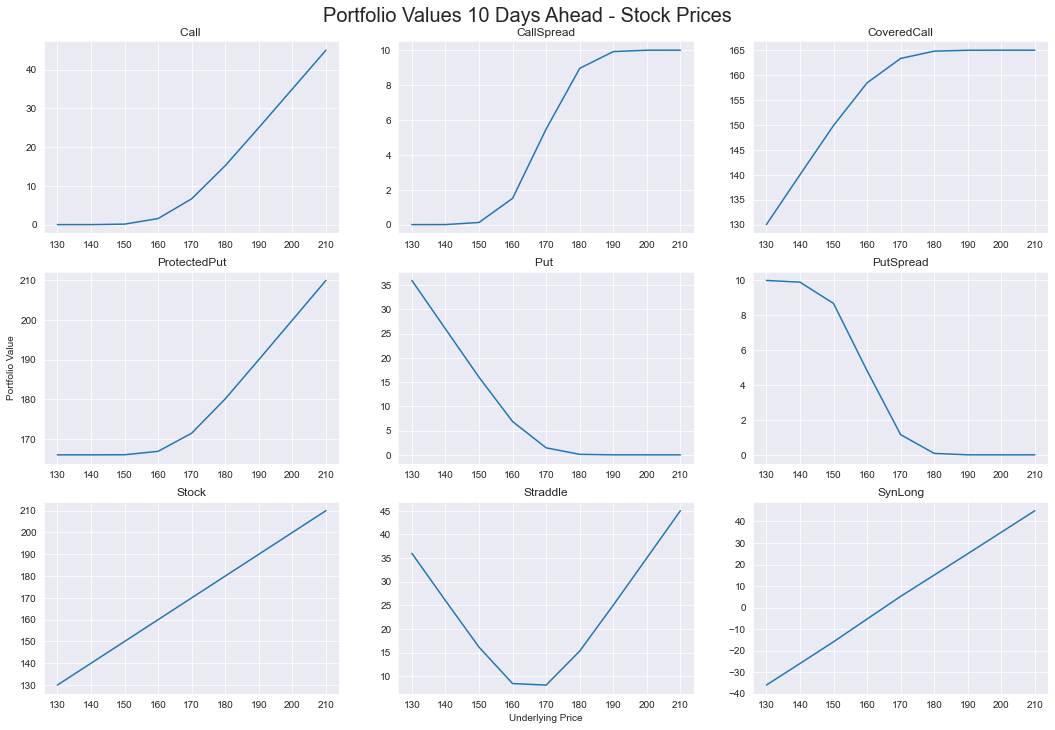

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Portfolio Values 10 Days Ahead - Stock Prices ", fontsize=20, y=0.92)
idx = 0
for pfl, df in pfl_sim_values(portfolios, np.linspace(130, 210, 9)).groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    sns.lineplot(x=np.linspace(130, 210, 9), y=df.iloc[0, :].values, ax=ax)
    ax.set_title(pfl)
    if i == 2 and j == 1:
        ax.set_xlabel('Underlying Price')
    if i == 1 and j == 0:
        ax.set_ylabel('Portfolio Value')
    idx += 1

We can calculate the mean, VaR and ES based on the simulated value change of each portfolio.  
The distributions of value changes are similar to that in Week 6's results. 

In [16]:
risk_metrics = pd.DataFrame(index=sim_value_chgs.index)
risk_metrics['mean'] = sim_value_chgs.mean(axis=1)
risk_metrics['VaR'] = sim_value_chgs.apply(lambda x:VaR(x, 0), axis=1)
risk_metrics['ES'] = sim_value_chgs.apply(lambda x:expected_shortfall(x), axis=1)

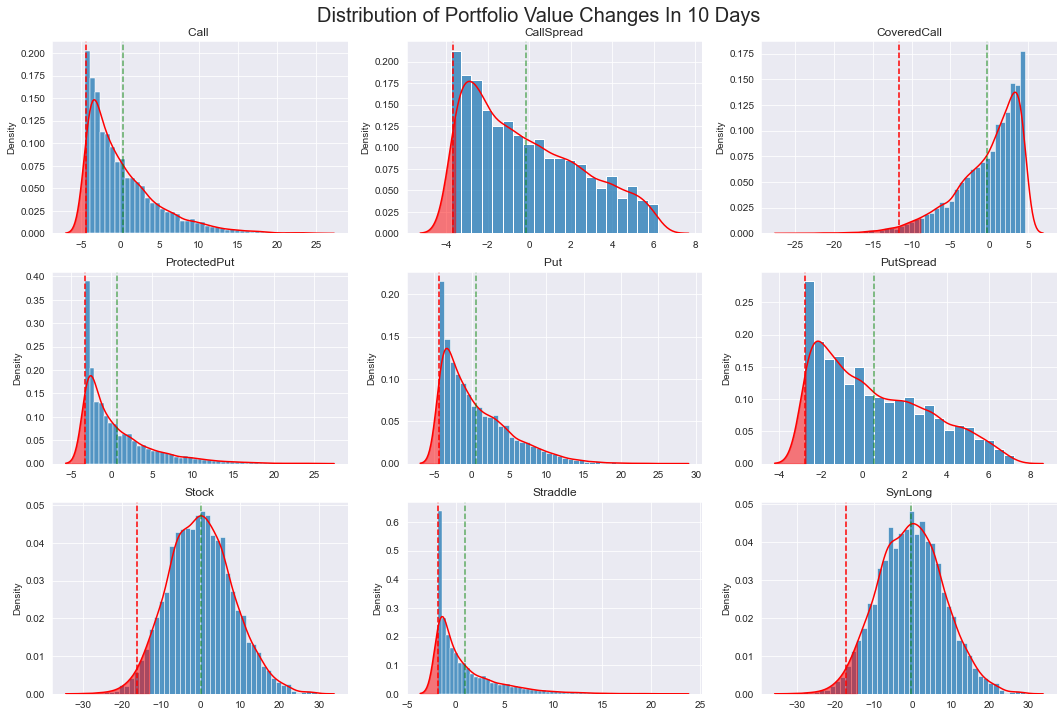

In [17]:
# plot the distribution of value changes in dollar of each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Distribution of Portfolio Value Changes In 10 Days", fontsize=20, y=0.92)

idx = 0
for pfl, df in sim_value_chgs.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    chgs = df.iloc[0, :].values
    sns.kdeplot(chgs, ax=ax, color='r')
    sns.histplot(chgs, ax=ax, stat='density')

    mean = risk_metrics.loc[pfl, 'mean']
    var = risk_metrics.loc[pfl, 'VaR']
    es = risk_metrics.loc[pfl, 'ES']

    ret, ret_density = ax.lines[0].get_data()
    ax.fill_between(ret, ret_density, where=(ret<-var), color='r', alpha=0.5)
    ax.axvline(-es, 0, 1, color='r', linestyle='--')
    ax.axvline(mean, 0, 1, color='green', linestyle='--', alpha=0.6)
    ax.set_title(pfl)

    idx += 1

### 2. Delta Normal

In [18]:
# calculate the delta of each asset
options = portfolios.loc[portfolios.Type == 'Option', :]
stocks = portfolios.loc[portfolios.Type == 'Stock', :]
options['delta'] = options.apply(
    lambda df: cal_amr_delta_num(df['IsCall'], price, df['Strike'], df['ttm'], 
                                    r_f, div_rate, df['ImpliedVol'], nperiods, df['Dividends']), 
    axis=1
)
stocks['delta'] = 1
portfolios = pd.concat([options, stocks], axis=0)


alpha = 0.05
t = 10
risk_metric_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['mean', 'VaR', 'ES'])
risk_metric_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
    gradient = price / df['CurrentValue'].sum() * (df['Holding'] * df['delta']).sum()
    pfl_10d_std = abs(gradient) * std * np.sqrt(t)
    N = scipy.stats.norm(0, 1)
    present_value = df['CurrentValue'].sum() 
    risk_metric_dn.loc[pfl]['mean'] = 0
    risk_metric_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
    risk_metric_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha


### 3. Compare the Results
The table and graphs for risk metrics is shown as below. We can discover that the VaR and ES of Normal Monte Carlo and Week 6 are very similar.

		Normal Monte Carlo			Delta Normal					Week6


,mean,VaR,ES
Portfolio,,,
Call,0.279583,4.262437,4.384050
CallSpread,-0.148644,3.543414,3.664331
CoveredCall,-0.257152,8.731492,11.679696
ProtectedPut,0.650785,3.197329,3.236329
Put,0.628354,4.238452,4.333030
PutSpread,0.531912,2.667040,2.745466
Stock,0.022431,12.993929,16.063746
Straddle,0.907937,1.814797,1.826428
SynLong,-0.348771,14.059037,17.211467


Text(0.5, 1.0, 'ES Comparison')

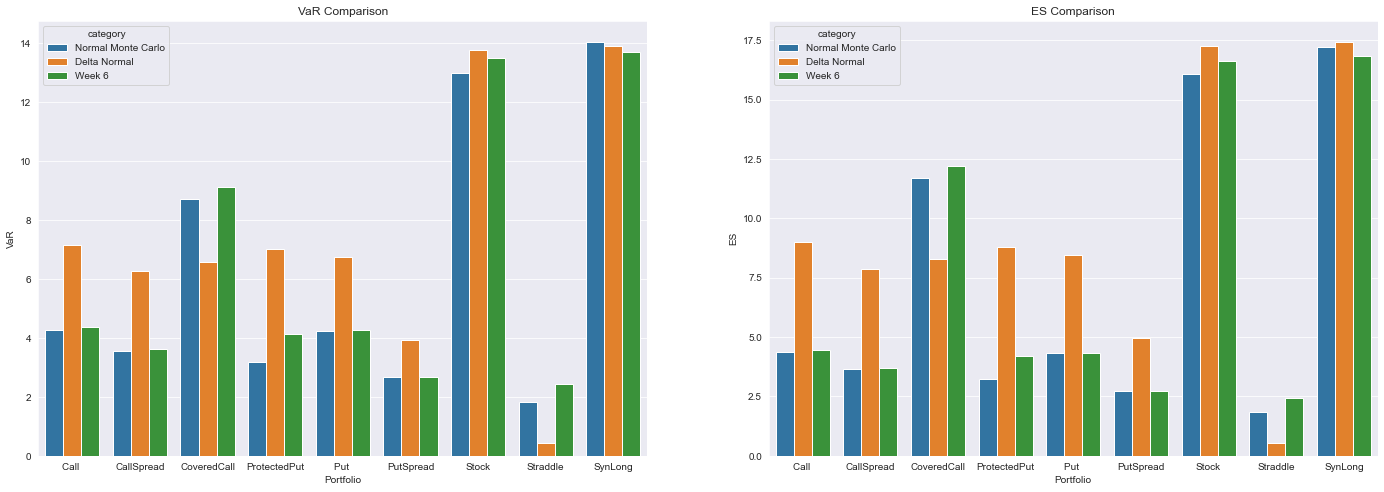

In [19]:
risk_metrics_week6 = pd.read_csv('week6_pfl_risk.csv').set_index('Portfolio')

from IPython.display import display_html 
def display_side_by_side(*args): 
    html_str='' 
    for df in args: 
     html_str+=df.to_html() 
    display_html(html_str.replace('table','table style="display:inline"'),raw=True) 
print('\t\tNormal Monte Carlo\t\t\tDelta Normal\t\t\t\t\tWeek6')
display_side_by_side(risk_metrics, risk_metric_dn, risk_metrics_week6)

risk_dfs = []
for category, risk_df in zip(['Normal Monte Carlo', 'Delta Normal', 'Week 6'], [risk_metrics, risk_metric_dn, risk_metrics_week6]):
    new_risk_df = risk_df.reset_index()
    new_risk_df['category'] = category
    risk_dfs.append(new_risk_df)
risk_dfs = pd.concat(risk_dfs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))
ax = sns.barplot(x='Portfolio', y='VaR', hue='category', data=risk_dfs, ax=axes[0])
ax.set_title('VaR Comparison')

ax = sns.barplot(x='Portfolio', y='ES', hue='category', data=risk_dfs, ax=axes[1])
ax.set_title('ES Comparison')

# Problem 3
Use the Fama French 3 factor return time series (F-F_Research_Data_Factors_daily.CSV) as well as the
Carhart Momentum time series (F-F_Momentum_Factor_daily.CSV) to fit a 4 factor model to the following
stocks.  

|||||
|  ----  | ----  |----|----|
|AAPL |FB |UNH |MA|  
|MSFT |NVDA| HD |PFE|  
|AMZN |BRK-B| PG |XOM | 
|TSLA |JPM |V |DIS | 
|GOOGL| JNJ| BAC| CSCO|  

Fama stores values as percentages, you will need to divide by 100 (or multiply the stock returns by 100)
to get like units.  
Based on the past 10 years of factor returns, find the expected annual return of each stock.
Construct an annual covariance matrix for the 10 stocks.  
Assume the risk free rate is 0.0025. Find the super efficient portfolio.  

## Solution

### Step 1
Based on the multi-factor model, we can use 60 day's daily return in DailyReturn.csv as the dependent variable to estimate the values of betas.
$$r - r_{f} = \alpha + \beta_1*(r_{mkt} - r_f) + \beta_2*SMB  + \beta_3*HML + \beta_4*Mom + \epsilon$$

Then we can use them to calculate the expected daily return in the past 10 years, suppose $E(\alpha)=0$.
$$E(r) = E(r_f) + \beta_1*E(r_{mkt} - r_f) + \beta_2*E(SMB)  + \beta_3*E(HML) + \beta_4*E(Mom)$$

### Step 2
To annualize the average daily return and its covariance, we may convert the arithmetic returns(denoted by $r$) into geometric returns(denoted by $g$). 
$$g = log(1+r)$$
and 
$$r = e^g - 1$$

Suppose the geometric daily returns follows a normal distribution $N(\Mu, \Sigma)$, then the annualized mean vector and covariance matrix would be $255\Mu$ and $255\Sigma$. 

### Step 3
To construct the most efficient protfolio using the efficient frontier, we still need to calculate the mean and covariance of arithmetic annual return ($r$) using those of the geometric annual return ($g$). Since g follows
a normal distribution $N(\mu_i, \sigma_i)$, r follows a log-normal distribution whose mean is:
$$E(r_i) = E(e^{g_i} - 1) = exp(\mu_i + \frac{\sigma_i^2}{2}) - 1$$

The covariance between $r_i$, $r_j$ is:
$$cov(r_i, r_j) = E(r_i * r_j) - E(r_i) * E(r_j) = E[(e^{g_i} - 1)(e^{g_j} - 1)]- E(e^{g_i} - 1)E(e^{g_j} - 1) = E(e^{g_i + g_j}) - E(e^{g_i})E(e^{g_j})$$

Since $g_i + g_j \sim N(\mu_i + \mu_j, \sigma_{i+j})$ , where $\sigma_{i+j} =\sqrt{\sigma_i^2 + \sigma_j^2 + 2\sigma_{ij}} $, 

$$cov(r_i, r_j) = exp(\mu_i + \mu_j + \frac{\sigma_i^2 + \sigma_j^2 + 2\sigma_{ij}}{2}) - exp(\mu_i + \frac{\sigma_i^2}{2}) * exp(\mu_j + \frac{\sigma_j^2}{2}) = exp(\mu_i + \mu_j + \frac{\sigma_i^2 + \sigma_j^2}{2})*(e^{\sigma_{ij}} - 1) $$

### Step 4
Now with mean and covariance of arithmetic returns, we can search for the most efficient portfolio, which has the highest Sharpe Ratio.

In [20]:
ff_3 = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
ff_4th = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date')
ff_4 = ff_3.join(ff_4th, how='right') / 100  # turn pct values into actual numbers
all_rets = pd.read_csv('DailyReturn.csv', parse_dates=['Date']).set_index('Date')
stocks = ['AAPL', 'FB', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'Mom']
dataset = all_rets[stocks].join(ff_4)


# 1. calculate arithmetic E(r) in past 10 years
avg_factor_rets = ff_4.loc['2012-1-14':'2022-1-14'].mean(axis=0)
avg_daily_rets = pd.Series()
for stock in stocks:
    # calculate betas
    # r_stock - r_f = alpha + sum(beta_i * factor_i) + error
    model = sm.OLS(dataset[stock] - dataset['RF'], sm.add_constant(dataset[factors]))
    results = model.fit()
    
    # E(r_stock) = alpha + sum(beta_i * E(factor_i)) + E(r_f)
    # assume alpha = 0
    avg_daily_rets[stock] = (results.params[factors] * avg_factor_rets[factors]).sum() \
                            + avg_factor_rets['RF'] 


# 2. geometric annual returns: mean and covariance
geo_means = np.log(1 + avg_daily_rets)*255  
geo_covariance = np.log(1 + all_rets[stocks]).cov()*255     


# 3. arithmetic annual returns: mean and covariance
arith_means = np.exp(geo_means + np.diagonal(geo_covariance.values) / 2) - 1

nstocks = geo_covariance.shape[0]
arith_covariance = np.empty((nstocks, nstocks), dtype=float)
for i in range(nstocks):
    for j in range(i, nstocks):
        mu_i, mu_j = geo_means.iloc[i], geo_means.iloc[j]
        sigma2_i, sigma2_j = geo_covariance.iloc[i, i], geo_covariance.iloc[j, j]
        sigma_ij = geo_covariance.iloc[i, j]
        arith_covariance[i, j] = np.exp(mu_i + mu_j + (sigma2_i + sigma2_j) / 2) * (np.exp(sigma_ij) - 1)
        arith_covariance[j, i] = arith_covariance[i, j]
arith_covariance = pd.DataFrame(arith_covariance, columns=stocks, index=stocks)


# 4. calculate the most efficient portfolio which has the highest Sharpe ratio 
def neg_sharpe_ratio(weights, mean, cov, r_f):
    returns = mean @ weights.T
    std = np.sqrt(weights @ cov @ weights.T)
    return -(returns - r_f) / std

args = (arith_means, arith_covariance, 0.0025)
bounds = ((0.0, 0.1) for _ in stocks)
x0 = np.array(nstocks*[1 / nstocks])
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
results = scipy.optimize.minimize(neg_sharpe_ratio, x0=x0, args=args, bounds=bounds, constraints=constraints)
opt_sharpe, opt_weights = -results.fun, pd.Series(results.x, index=stocks)
opt_weights = pd.DataFrame(opt_weights, columns=['weights(%)'])
opt_weights['weights(%)'] = round(opt_weights*100, 2)

print("The most efficient portfolio consists of: ")
display(opt_weights)
print(f"The Portfolio's Sharpe Ratio is: {opt_sharpe:.2f}")

The most efficient portfolio consists of: 


,weights(%)
AAPL,0.00
FB,5.45
UNH,5.32
MA,2.96
MSFT,2.12
NVDA,0.18
HD,5.23
PFE,6.35
AMZN,10.00
BRK-B,10.00


The Portfolio's Sharpe Ratio is: 1.32
